# Run parallel calls to OpenAI on a dataset, with rate limit

In this notebook, you'll learn how to run multiple parallel calls to OpenAI on a dataset with a rate limit. 

As an example, we'll take a bunch of Amazon reviews as a dataset. Our goal is to **extract keywords** from the reviews. The way we extract keywords is by making a call to OpenAI GPT-4 and asking to list the keywords. 

To do that, here is what we will do:

1. Load the dataset
2. Make API calls to OpenAI
3. Parallelize the calls while respecting the OpenAI rate limits
4. Displaying results

Let's go!

In [ ]:
!pip install "phospho[lab]"

In [1]:
import pandas as pd
import re
import os
import openai 

from phospho import lab
from dotenv import load_dotenv

load_dotenv()

assert os.environ.get("OPENAI_API_KEY"), "Please set the OPENAI_API_KEY environment variable."

## Load dataset

For demonstration purposes, we'll use a subset of the [Amazon Reviews dataset, collected in 2023 by McAuley Lab](https://amazon-reviews-2023.github.io).

In [2]:
messages_df = pd.read_csv('data/Magazine_Subscriptions_5.csv')
# Create a new column to store the message id
messages_df["id"] = messages_df.index.astype(str)

In [3]:
messages_df.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,id
0,4,True,"02 26, 2014",A5QQOOZJOVPSF,B00005N7P0,John L. Mehlmauer,"I'm old, and so is my computer. Any advice th...",Cheapskates guide,1393372800,NaN,NaN,NaN,0


The first thing we need to do is to transform this dataset in a list of phospho `lab.Message`, which is a data format more adapted for what we need to do. 

In [4]:
# Convert every valid row of the df into a lab.Message
messages = lab.Message.from_df(messages_df, content="reviewText", created_at="unixReviewTime", id="id")
messages[:4]

[Message(id='0', created_at=1393372800, role=None, content="I'm old, and so is my computer.  Any advice that can help me maximize my computer perfomance is very welcome.  MaximumPC has some good tips on computer parts, vendors, and usefull tests", previous_messages=[], metadata={}),
 Message(id='1', created_at=1078531200, role=None, content="There's nothing to say, but if you want a REAL men's magazine, this is it. They have great articles and stories, and I love the bits of knowledge that starts the Know & Tell section, and I love the last page, which has an interview with a celebrity. Just get this magazine and forget all the other mature men's mags.", previous_messages=[], metadata={}),
 Message(id='2', created_at=1058227200, role=None, content="If you're the kind of man who looks at himself in a full length mirrror every morning, this is the magazine for you.\nIf you think the car you drive defines you, the clothes you wear are the measure of your self-worth, the watch on your wris

## Make API calls to OpenAI

Let's create a function that takes a message content as an input, and then make a call to OpenAI to get a list of keywords. 

### Step by step

First, we'll take a message. 

In [5]:
message = messages[0]
message

Message(id='0', created_at=1393372800, role=None, content="I'm old, and so is my computer.  Any advice that can help me maximize my computer perfomance is very welcome.  MaximumPC has some good tips on computer parts, vendors, and usefull tests", previous_messages=[], metadata={})

Then, we embed it into a prompt that we make to OpenAI.

In [9]:
openai_client = openai.AsyncClient(api_key=os.environ["OPENAI_API_KEY"])

# Label every message with keywords it contains
prompt = f"""You are an annotator reading Amazon product reviews. Your job is to label
each review with keywords that describe the main topics covered in the review.
The review is: 
{message.content}

Return a list of max 10 keywords as a bullet point list: `- keyword1\n- keyword2\n- keyword3`
Keywords:"""

response = await openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": "You are a business analyst, expert in e-commerce.",
        },
        {"role": "user", "content": prompt},
    ],
)
response.choices[0].message.content

'- Computer performance optimization\n- Aging computer\n- Advice\n- MaximumPC\n- Computer parts\n- Vendors\n- Useful tests'

Finally, we use regex to read the response. 

In [7]:
response = response.choices[0].message.content
# Parse the response to extract the keywords with regex
keywords = re.findall(r"- (.*)", response)
keywords

['Old computer',
 'Computer performance',
 'MaximumPC',
 'Computer parts',
 'Vendors',
 'Useful tests',
 'Advice',
 'Optimization',
 'Maximize performance']

### Turn this into a phospho job

Okay, let's muscle up and turn this proof of concept into a function.

However, let's respect the phospho job convention. To respect the convention, we need the function to take a lab.Message as an input, and return a lab.JobResult as an output.

Respecting this format helps us parallelize the calls later on. 

Here's what the function looks like:

In [10]:
async def get_keywords(
    message: lab.Message,
    model: str="openai:gpt-3.5-turbo",
) -> lab.JobResult:
    """
    This function uses OpenAI GPT to extract keywords from a given message.
    """
    provider, model_name = lab.get_provider_and_model(model)
    openai_client = lab.get_async_client(provider)

    # Label every message with keywords it contains
    prompt = f"""You are an annotator reading Amazon product reviews. Your job is to label
    each review with keywords that describe the main topics covered in the review.
    The review is: 
    {message.content}

    Return a list of max 10 keywords as a bullet point list: `- keyword1\n- keyword2\n- keyword3`
    Keywords:"""

    response = await openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are a business analyst, expert in e-commerce.",
            },
            {"role": "user", "content": prompt},
        ],
    )

    response = response.choices[0].message.content
    # Parse the response to extract the keywords with regex
    keywords = re.findall(r"- (.*)", response)
    return lab.JobResult(
        value=keywords,
        result_type=lab.ResultType.list,
    )

Easy, right ? Let's try the function on a single keyword:

In [11]:
# Try the function one a single message
await get_keywords(messages[0])

JobResult(value=['computer performance', 'MaximumPC', 'tips', 'computer parts', 'vendors', 'useful tests', 'advice', 'maximize', 'old computer', 'performance optimization'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710799643, job_id=None)

## Run the job on multiple messages

Now, let's run the jobs on the dataset. 

With a simple for loop, you have to wait for a full API call to complete before running the next one. This takes a long time. 

**Parallelization** helps you make multiple calls at the same time to speed up generation.

However, OpenAI and model providers have set up **rate limits.** This means your requests will fail if you make too many requests, too fast.

To circumvent this, phospho has a `max_parallelism` parameter, which **purposefully slow down parallel calls.** 

In [12]:
workload = lab.Workload(jobs=[lab.Job(job_function=get_keywords)])

# Run the workload on the messages
await workload.async_run(
    messages[:100], # Replace by messages to run on the whole dataset
    executor_type="parallel", # Run the job on every messages in parallel
    max_parallelism=10, # Start at most 10 jobs per second to avoid rate limiting
)

No job_config provided. Running with empty config
100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


{'0': {'get_keywords': JobResult(value=['computer performance', 'tips', 'computer parts', 'vendors', 'tests', 'MaximumPC', 'advice', 'maximize', 'old computer', 'useful'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710799650, job_id='get_keywords')},
 '1': {'get_keywords': JobResult(value=["men's magazine", 'great articles', 'stories', 'Know & Tell section', 'interview with a celebrity', "mature men's magazines"], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710799650, job_id='get_keywords')},
 '2': {'get_keywords': JobResult(value=['self-image', 'materialism', 'status symbol', 'relationships', 'magazine', 'lifestyle', 'appearance', 'social status'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710799650, job_id='get_keywords')},
 '3': {'get_keywords': JobResult(value=['Advertisement', 'Little content', 'Article'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710799649, job

## Display results

Let's get the results in a format more adapted for analytics.

In [18]:
results_df = workload.results_df()
results_df.head(3)

,get_keywords
0,"[computer performance, tips, computer parts, v..."
1,"[men's magazine, great articles, stories, Know..."
10,"[glamour mag, articles, clothes, beauty, long-..."


And join back the outputs with the original dataframe. 

In [19]:
augmented_messages_df = results_df.merge(messages_df, left_index=True, right_on="id")
augmented_messages_df.head(3)

,get_keywords,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,id
0,"[computer performance, tips, computer parts, v...",4,True,"02 26, 2014",A5QQOOZJOVPSF,B00005N7P0,John L. Mehlmauer,"I'm old, and so is my computer. Any advice th...",Cheapskates guide,1393372800,NaN,NaN,NaN,0
1,"[men's magazine, great articles, stories, Know...",5,False,"03 6, 2004",A5RHZE7B8SV5Q,B00005N7PS,gorillazfan249,"There's nothing to say, but if you want a REAL...",The best mature Men's magazine.,1078531200,3.0,NaN,NaN,1
10,"[glamour mag, articles, clothes, beauty, long-...",5,True,"06 12, 2017",A2VRQ8RNTKY1XT,B00005N7QC,Barbara M. Fox,I love glamour mag. I have read it for over 25...,Great magazine,1497225600,NaN,{'Format:': ' Kindle Edition'},NaN,10


We can now have tons of fun with the extracted keywords and do all kind of data analytics. 

<Axes: title={'center': 'Most common keywords in the dataset'}, xlabel='get_keywords'>

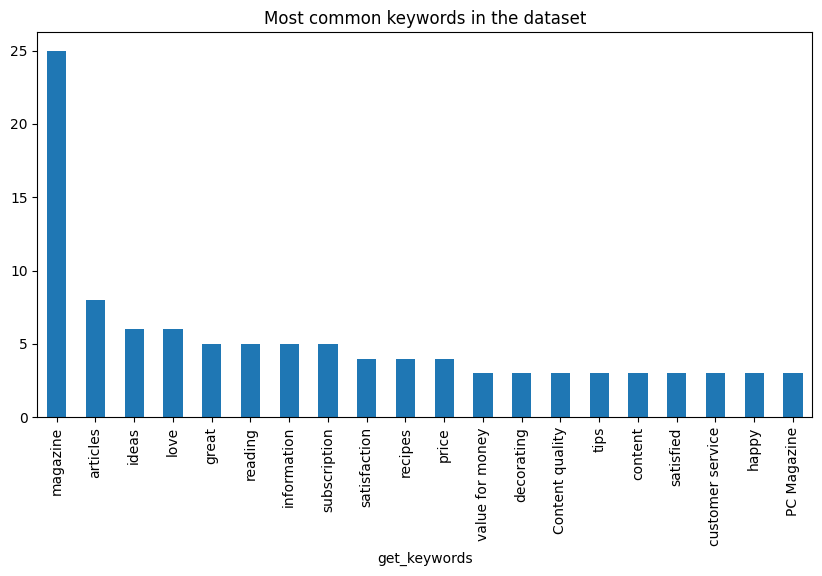

In [34]:
# Eg: Count the number of messages that contain a specific keyword

keywords_to_count = augmented_messages_df.explode("get_keywords").groupby("get_keywords").size().sort_values(ascending=False)

keywords_to_count.head(20).plot(kind="bar", figsize=(10, 5), title="Most common keywords in the dataset")